In [1]:
import os
import glob
import pandas as pd
from sklearn.model_selection import StratifiedKFold

In [3]:
def _in_dataframe(data_array, df):
    df = df.reset_index(drop=True)
    df['type'] = df['Subject ID'].apply(lambda x: True if x in data_array else False)
    return df[df.type].reset_index(drop=True)

def get_split(dt, age_range, test_size):
    split = dt[(dt.Age >= age_range[0]) & (dt.Age < age_range[1])]
    print(split.shape)
    unique_subjs = split.drop_duplicates('Subject ID', keep='first').reset_index(drop=True)

    delta = unique_subjs['Age'].max() - unique_subjs['Age'].min()
    discrete = pd.cut(unique_subjs['Age'], bins=int(delta/3), right=False).reset_index(drop=True).astype(str)
    unique_subjs['Age_disc'] = discrete
    skf = StratifiedKFold(n_splits=15)
    idx = [(train_index, test_index) for train_index,
                                         test_index in skf.split(unique_subjs['Subject ID'],
                                                                 unique_subjs['Age_disc'])][0]
    train_idx, test_idx = idx[0], idx[1]
    train = unique_subjs.iloc[train_idx]
    test = unique_subjs.iloc[test_idx]

    skf = StratifiedKFold(n_splits=14)
    idx = [(train_index, val_index) for train_index,
                                        val_index in skf.split(train['Subject ID'],
                                                               train['Age_disc'])][0]
    train_idx, val_idx = idx[0], idx[1]
    
    print("Unique train", len(train_idx), 'val', len(val_idx), 'test', len(test_idx))
    train_data = unique_subjs.iloc[train_idx]
    train = _in_dataframe(train_data.values, split)
    val = unique_subjs.iloc[val_idx]
    print("Final train", len(train), 'val', len(val), 'test', len(test))
    print(train.Age.describe(), val.Age.describe(), test.Age.describe())
    return train, val, test


## Information for ADNI images

In [2]:
adni = pd.read_csv(os.path.join("database_info", "ADNI_data_information.csv"))
# Only CN subjects
adni_cn = adni[adni['Research Group'] == 'CN'].reset_index(drop=True)
adni_cn.head()

,Subject ID,Phase,Sex,Weight,Research Group,APOE A1,APOE A2,Visit,Archive Date,Study Date,Age,MMSE Total Score,GDSCALE Total Score,Global CDR,FAQ Total Score,NPI-Q Total Score,Modality,Description,Image ID,Image Filename
0,006_S_0731,ADNI 3,M,62.0,CN,3.0,3.0,ADNI3_Initial_Visit-Cont_Pt,9/19/2017,9/18/2017,82.7,NaN,NaN,NaN,NaN,NaN,MRI,Sagittal 3D Accelerated MPRAGE,905360,006_S_0731_ADNI3_Initial_Visit-Cont_Pt.nii.gz
1,035_S_4464,ADNI 3,M,83.9,CN,3.0,4.0,ADNI3_Initial_Visit-Cont_Pt,2/06/2018,2/01/2018,76.4,NaN,NaN,NaN,NaN,NaN,MRI,Accelerated Sagittal MPRAGE,959742,035_S_4464_ADNI3_Initial_Visit-Cont_Pt.nii.gz
2,035_S_0555,ADNI 1,M,77.0,CN,3.0,4.0,ADNI1GO_Month_6,5/25/2007,5/24/2007,77.7,30.0,NaN,0.0,0.0,0.0,MRI,MPRAGE,55241,035_S_0555_ADNI1GO_Month_6.nii.gz
3,018_S_4399,ADNI 2,F,56.7,CN,3.0,4.0,ADNI2_Year_2_Visit,1/06/2014,1/06/2014,80.1,29.0,1.0,0.0,0.0,NaN,MRI,MPRAGE,403909,018_S_4399_ADNI2_Year_2_Visit.nii.gz
4,007_S_1222,ADNI 3,F,81.6,CN,2.0,3.0,ADNI3_Initial_Visit-Cont_Pt,1/18/2018,1/17/2018,84.4,NaN,NaN,NaN,NaN,NaN,MRI,Accelerated Sagittal MPRAGE,955206,007_S_1222_ADNI3_Initial_Visit-Cont_Pt.nii.gz


## IXI

In [4]:
ixi = pd.read_csv(os.path.join("database_info", "IXI_data_information.csv"))
ixi['Subject ID'] = ixi['Image Filename']
ixi['Research Group'] = 'CN'
ixi['Image Filename'].shape, ixi['Image Filename'].nunique()

((563,), 563)

## Experiment images

In [5]:
adni_exp = pd.read_csv(os.path.join("database_info", "ADNI_experiment_information.csv"))

### Remove experiment images (To be used for the final validation and test)

In [6]:
cn_exp = adni_exp[adni_exp['Research Group'] == 'CN'].reset_index(drop=True)
cn_exp['Image Filename'] = cn_exp[['Subject ID', 'Visit']].apply(lambda x: x[0]+'_'+x[1].replace(' ', '_').replace('/', '')+".nii.gz", axis=1)

# Remove cn_exp images
adni_cn['CN'] = adni_cn['Subject ID'].apply(lambda x: True if x in cn_exp['Subject ID'].values else False)
adni_imgs = adni_cn[~adni_cn.CN].reset_index(drop=True)
adni_imgs['Image Filename'] = adni_imgs['Image Filename'].apply(lambda x: x.split(".nii")[0])
adni_imgs.shape


(540, 21)

## Create train, test and validation datasets [70-100]

In [7]:
# Train ADNI between 70 and 100 years
train_adni = adni_imgs[adni_imgs.Age >= 70].reset_index(drop=True)
print("ADNI\nFinal train", len(train_adni), "images with", train_adni['Subject ID'].nunique(), "unique subjects")

# Train IXI between 70 and 100 years
train_ixi = ixi[ixi.Age >= 70].reset_index(drop=True)
print("IXI\nFinal train", len(train_ixi), "images with", train_ixi['Subject ID'].nunique(), "unique subjects")

# Train 0 and 70 years ADNI+IXI
cols = ['Subject ID', 'Age', 'Research Group', 'Image Filename']
train_70100 = pd.concat([train_adni[cols], train_ixi[cols]])
print("Train IXI/ADNI", len(train_70100))
# train_70100.to_csv("train_70-100.csv", index=False)

ADNI
Final train 272 images with 167 unique subjects
IXI
Final train 57 images with 57 unique subjects
Train IXI/ADNI 329


In [8]:
# Divide CN exp images between test and validation sets
cn_exp['Image Filename'] = cn_exp['Image Filename'].apply(lambda x: x.split(".nii")[0])

delta = cn_exp['Age'].max() - cn_exp['Age'].min()
cn_exp['Age_disc'] = pd.cut(cn_exp['Age'], bins=int(delta/3), right=False).reset_index(drop=True).astype(str)
skf = StratifiedKFold(n_splits=2)
val_idx = [val_index for val_index, _ in skf.split(cn_exp['Subject ID'],
                                                   cn_exp['Age_disc'])][0]

val = cn_exp.iloc[val_idx]
test = cn_exp.iloc[~val_idx]
print("70-100\nVal", len(val), 'test', len(test))
test.to_csv("test_70-100.csv", index=False)
val.to_csv("val_70-100.csv", index=False)

70-100
Val 151 test 151


## Create train, test and validation datasets [0-70]

In [9]:
# Train, val, test split for ADNI between 0 and 70 years
print("ADNI")
train_adni, val_adni, test_adni = get_split(adni_imgs, [0, 70], .1)
print("IXI")
# Train, val, test split for IXI between 0 and 70 years
train_ixi, val_ixi, test_ixi = get_split(ixi, [0, 70], .1)

# Train 0 and 70 years ADNI+IXI
cols = ['Subject ID', 'Age', 'Research Group', 'Image Filename']
train_070 = pd.concat([train_adni[cols], train_ixi[cols]])
print("Train IXI/ADNI", len(train_070))
# train_070.to_csv("train_0-70.csv", index=False)

# Val 0 and 70 years ADNI+IXI
val_070 = pd.concat([val_adni[cols], val_ixi[cols]])
print("Val IXI/ADNI", len(val_070))
# val_070.to_csv("val_0-70.csv", index=False)

# Test 0 and 70 years ADNI+IXI
test_070 = pd.concat([test_adni[cols], test_ixi[cols]])
print("Test IXI/ADNI", len(test_070))
# test_070.to_csv("test_0-70.csv", index=False)

ADNI
(268, 21)
Unique train 135 val 11 test 11
Final train 225 val 11 test 11
count    225.000000
mean      65.765333
std        2.991797
min       55.800000
25%       64.800000
50%       66.200000
75%       67.800000
max       69.900000
Name: Age, dtype: float64 count    11.000000
mean     65.872727
std       3.165151
min      59.100000
25%      64.600000
50%      66.800000
75%      67.850000
max      69.500000
Name: Age, dtype: float64 count    11.000000
mean     65.290909
std       3.166530
min      59.100000
25%      63.200000
50%      65.400000
75%      67.850000
max      69.000000
Name: Age, dtype: float64
IXI
(506, 15)
Unique train 438 val 34 test 34
Final train 438 val 34 test 34
count    438.000000
mean      46.289840
std       14.790354
min       19.980000
25%       33.032500
50%       46.235000
75%       60.027500
max       69.690000
Name: Age, dtype: float64 count    34.000000
mean     37.856765
std      11.860377
min      21.570000
25%      29.335000
50%      34.190000
75%

<AxesSubplot:ylabel='Frequency'>

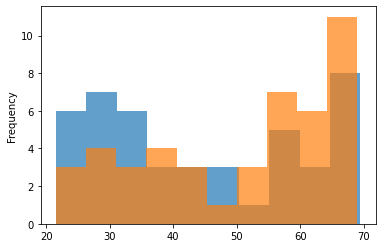

In [12]:
val_070.Age.plot(kind='hist', alpha=0.7)
test_070.Age.plot(kind='hist', alpha=0.7)

## Format csv for all images

In [10]:
# All images
all_ = pd.concat([adni_imgs[cols], ixi[cols]])
print(all_.shape)
all_.to_csv("train_all.csv", index=False)

(1103, 4)


## AD and MCI

In [11]:
# adni_exp contains AD and MCI images

ad = adni_exp[adni_exp['Research Group'] == 'AD'].reset_index(drop=True)
mci = adni_exp[adni_exp['Research Group'] == 'MCI'].reset_index(drop=True)
ad['Image Filename'] = ad[['Subject ID','Visit']].apply(lambda x: x[0] + "_" + x[1].replace(" ", "_").replace("/", ""), axis=1)
ad = ad[['Subject ID', 'Age', 'Research Group', 'Image Filename']]
mci['Image Filename'] = mci[['Subject ID','Visit']].apply(lambda x: x[0] + "_" + x[1].replace(" ", "_").replace("/", ""), axis=1)
mci = mci[['Subject ID', 'Age', 'Research Group', 'Image Filename']]
print("AD", len(ad), "MCI", len(mci))
ad.to_csv("ad_70-100.csv", index=False)
mci.to_csv("mci_70-100.csv", index=False)

AD 209 MCI 251
